# Noisy DQN, Deep Q Learning

In [1]:
import os
import math
import random
import numpy as np
import matplotlib.pyplot as plt

from collections import namedtuple, deque

In [2]:
import gym
import torch
import torch.nn as nn
import torch.optim as optim
import torch.autograd as autograd
import torch.nn.functional as F
import torchvision.transforms as T

In [3]:
import warnings
warnings.simplefilter('ignore', UserWarning)

In [4]:
plt.style.use('ggplot')

## Set Configs

In [5]:
is_cuda = torch.cuda.is_available()

if is_cuda: device = torch.device('cuda')
else: device = torch.device('cpu')

In [6]:
BUFFER_SIZE = int(1e5)
BATCH_SIZE = 64
GAMMA = 0.99
TAU = 1e-3 # for soft update of target parameters
LR = 5e-4
PRINT_EVERY = 100
UPDATE_EVERY = 4

## Set Environment

In [7]:
ENV_NAME = 'LunarLander-v2'
env = gym.make(ENV_NAME).unwrapped; env.seed(90);

In [8]:
print('Environment Display:')
env.reset() # reset environment to a new, random state
env.render()

print('State space {}'.format(env.observation_space))
print('Action space {}'.format(env.action_space))

Environment Display:
State space Box(8,)
Action space Discrete(4)


## Build Noisy Network

In [9]:
class NoisyLinear(nn.Module):
    
    def __init__(self, input_features, output_features, sigma_init=0.4, train_mode=True):
        
        super(NoisyLinear, self).__init__()
        
        self.input_features = input_features
        self.output_features = output_features
        self.sigma_init = sigma_init
        self.train_mode = train_mode
        
        self.mu_weight = nn.Parameter(torch.FloatTensor(output_features, input_features))
        self.sigma_weight = nn.Parameter(torch.FloatTensor(output_features, input_features))
        self.register_buffer('epsilon_weight', torch.FloatTensor(output_features, input_features))
        
        self.mu_bias = nn.Parameter(torch.FloatTensor(output_features))
        self.sigma_bias = nn.Parameter(torch.FloatTensor(output_features))
        self.register_buffer('epsilon_bias', torch.FloatTensor(output_features))
        
        self.reset_parameters()
        self.reset_noise()
        
    def reset_parameters(self):
        
        mu_range = 1 / math.sqrt(self.mu_weight.size(1))
        
        self.mu_weight.data.uniform_(-mu_range, mu_range)
        self.sigma_weight.data.fill_(self.sigma_init / math.sqrt(self.sigma_weight.size(1)))
        
        self.mu_bias.data.uniform_(-mu_range, mu_range)
        self.sigma_bias.data.fill_(self.sigma_init / math.sqrt(self.sigma_bias.size(0)))
    
    def reset_noise(self):
        
        input_size = self.input_features
        epsilon_input = torch.randn(input_size)
        epsilon_input = epsilon_input.sign().mul(epsilon_input.abs().sqrt())
        
        output_size = self.output_features
        epsilon_output = torch.randn(output_size)
        epsilon_output = epsilon_output.sign().mul(epsilon_output.abs().sqrt())
        
        self.epsilon_weight.copy_(epsilon_output.ger(epsilon_input))
        self.epsilon_bias.copy_(epsilon_output)
        
    def forward(self, x):
        
        if self.train_mode:
            weight = self.mu_weight + self.sigma_weight.mul(autograd.Variable(self.epsilon_weight))
            bias = self.mu_bias + self.sigma_bias.mul(autograd.Variable(self.epsilon_bias))
        else:
            weight = self.mu_weight
            bias = self.mu_bias
            
        return F.linear(x, weight, bias)

## Build DQN Architecture

In [10]:
class DQN(nn.Module):
    """Define DQN architecture."""
    
    def __init__(self, state_size, action_size, seed, fcl_units=64, fc2_units=64):
        """Initialize parameters and build model."""
        
        super(DQN, self).__init__()
        
        self.seed = torch.manual_seed(seed)
        
        self.fc1_layer = nn.Linear(state_size, fcl_units)
        self.noisy1_layer = NoisyLinear(fcl_units, fc2_units)
        self.noisy2_layer = NoisyLinear(fc2_units, action_size)
        
    def reset_noise(self):
        self.noisy1_layer.reset_noise()
        self.noisy2_layer.reset_noise()
        
    def forward(self, state):
        """Build a network that maps state into action values."""
        
        state = F.relu(self.fc1_layer(state))
        state = F.relu(self.noisy1_layer(state))
        Qsa = self.noisy2_layer(state)
        
        return Qsa        

## Set Replay Buffer

In [11]:
class ReplayBuffer(object):
    """Fixed-size buffer to store experience tuples."""
    
    def __init__(self, action_size, buffer_size, batch_size, seed):
        """Initialize a ReplayMemory object."""
        
        self.experience = namedtuple("Experience", field_names=["state", "action", "reward", "next_state", "done"])
        self.seed = random.seed(seed)
        
        self.action_size = action_size
        self.memory = deque(maxlen=buffer_size)
        self.batch_size = batch_size

    def add(self, state, action, reward, next_state, done):
        """Add a new experience to buffer."""
        
        self.memory.append(self.experience(state, action, reward, next_state, done))
        
    def sample(self):
        """Randomly sample a batch of experiences from memory."""
        experiences = random.sample(self.memory, k=self.batch_size)
        
        states = torch.from_numpy(np.vstack([exp.state for exp in experiences if exp is not None])).float()
        states = states.to(device)
        
        actions = torch.from_numpy(np.vstack([exp.action for exp in experiences if exp is not None])).long()
        actions = actions.to(device)
        
        rewards = torch.from_numpy(np.vstack([exp.reward for exp in experiences if exp is not None])).float()
        rewards = rewards.to(device)
        
        next_states = torch.from_numpy(np.vstack([exp.next_state for exp in experiences if exp is not None])).float()
        next_states = next_states.to(device)
        
        dones = torch.from_numpy(np.vstack([exp.done for exp in experiences if exp is not None]).astype(np.uint8)).float()
        dones = dones.to(device)
        
        return (states, actions, rewards, next_states, dones)
        
    def __len__(self):
        """Return the current size of internal memory."""
        return len(self.memory)

## Define Noisy DQN Agent

In [12]:
class Noisy_DQNAgent():
    """The agent interacting with and learning from the environment."""
    
    def __init__(self, state_size, action_size, seed):
        """Initialize an agent object."""
        
        self.state_size = state_size
        self.action_size = action_size
        self.seed = random.seed(seed)
        
        # Q-Network
        self.dqn_net = DQN(state_size, action_size, seed).to(device)
        self.target_net = DQN(state_size, action_size, seed).to(device)
        self.optimizer = optim.Adam(self.dqn_net.parameters(), lr=LR)
        
        # Replay Buffer
        self.buffer = ReplayBuffer(action_size, BUFFER_SIZE, BATCH_SIZE, seed)
        self.time_step = 0
        
    def memorize(self, state, action, reward, next_state, done):
        """Save experience in replay buffer."""
        
        self.buffer.add(state, action, reward, next_state, done)
    
        self.time_step = (self.time_step + 1) % UPDATE_EVERY
        if self.time_step == 0:
            # if enough samples are available in memory, get random subset and learn
            if len(self.buffer) > BATCH_SIZE:
                experiences = self.buffer.sample()
                self.learn(experiences, GAMMA)
            
    def act(self, state, eps=0.):
        """Returns actions for given state as per current policy."""
        
        state = torch.from_numpy(state).float().unsqueeze(0).to(device)
        self.dqn_net.eval()
        with torch.no_grad():
            action_values = self.dqn_net(state)
        self.dqn_net.train()
        
        # epsilon-greedy action selection
        if random.random() > eps:
            return np.argmax(action_values.cpu().data.numpy())
        else:
            return random.choice(np.arange(self.action_size))
    
    def learn(self, experiences, gamma):
        """Update value parameters using given batch of experience tuples."""
    
        states, actions, rewards, next_states, dones = experiences
        
        self.optimizer.zero_grad()
        
        # get index of maximum value for next state
        Qsa_next = self.dqn_net(next_states).detach()
        _, action_max = Qsa_next.max(1)

        # get max predicted Q values (for next states) from target network
        Q_target_next = self.target_net(next_states).detach().gather(1, action_max.unsqueeze(1))
        
        # compute Q target
        Q_target = rewards + (gamma * Q_target_next * (1 - dones))
        
        # get expected Q values from dqn network
        Q_expected = self.dqn_net(states).gather(1, actions)
        
        # compute loss
        loss = F.mse_loss(Q_expected, Q_target)
        
        # minimize the loss
        loss.backward()
        self.optimizer.step()
        
        # update target network
        self.soft_update(self.dqn_net, self.target_net, TAU)
        
    def soft_update(self, dqn_net, target_net, tau):
        """Soft update target network parameters."""
        
        for dqn_param, target_param in zip(dqn_net.parameters(), target_net.parameters()):
            target_param.data.copy_(tau*dqn_param.data + (1.0-tau) * target_param.data)

In [13]:
agent = Noisy_DQNAgent(state_size=env.observation_space.shape[0], action_size=env.action_space.n, seed=90)

In [14]:
# watch an untrained agent
state = env.reset()
for time_step in range(200):
    
    # select an action
    action = agent.act(state)
    env.render()
    
    next_state, reward, done, _ = env.step(action)
    state = next_state
    if done:
        break

env.close()

## Train The Agent

In [15]:
def train_agent(num_episodes, max_time=1000, eps_start=1.0, eps_end=0.01, eps_decay=0.995):
    """Train DQN agent."""
    
    scores = []
    scores_window = deque(maxlen=100)
    eps = eps_start
    
    for i_episode in range(1, num_episodes+1):
        state = env.reset()
        score = 0
        for time_step in range(max_time):
            action = agent.act(state, eps)
            next_state, reward, done, _ = env.step(action)
            
            agent.memorize(state, action, reward, next_state, done)
            state = next_state
            score += reward
            if done:
                break
                
        scores_window.append(score)
        scores.append(score)
        eps = max(eps_end, eps_decay*eps)
        
        print(f'\rEpisode: {i_episode}, Average Score: {np.mean(scores_window):.2f}', end='')
        
        if i_episode % PRINT_EVERY == 0:
            print(f'\rEpisode: {i_episode}, Average Score: {np.mean(scores_window):.2f}')
        if np.mean(scores_window) >= 200.0:
            print(f'\nEnvironment solved in {i_episode-100:d} episodes! Average Score: {np.mean(scores_window):.2f}')
            if not os.path.exists('./agents/'): os.makedirs('./agents/')
            torch.save(agent.dqn_net.state_dict(), f'./agents/Noisy_DQN_with_EGP_{ENV_NAME}.pth')
            
    print('Training completed.')
    return scores

In [16]:
scores = train_agent(num_episodes=2000, max_time=1000)

Episode: 100, Average Score: -171.97
Episode: 200, Average Score: -94.835
Episode: 300, Average Score: -6.140
Episode: 400, Average Score: 92.22
Episode: 500, Average Score: 177.63
Episode: 579, Average Score: 200.75
Environment solved in 479 episodes! Average Score: 200.75
Episode: 580, Average Score: 201.37
Environment solved in 480 episodes! Average Score: 201.37
Episode: 581, Average Score: 201.20
Environment solved in 481 episodes! Average Score: 201.20
Episode: 582, Average Score: 200.84
Environment solved in 482 episodes! Average Score: 200.84
Episode: 583, Average Score: 201.13
Environment solved in 483 episodes! Average Score: 201.13
Episode: 584, Average Score: 201.34
Environment solved in 484 episodes! Average Score: 201.34
Episode: 585, Average Score: 202.19
Environment solved in 485 episodes! Average Score: 202.19
Episode: 586, Average Score: 201.91
Environment solved in 486 episodes! Average Score: 201.91
Episode: 587, Average Score: 202.61
Environment solved in 487 episo

Episode: 665, Average Score: 218.75
Environment solved in 565 episodes! Average Score: 218.75
Episode: 666, Average Score: 221.08
Environment solved in 566 episodes! Average Score: 221.08
Episode: 667, Average Score: 221.52
Environment solved in 567 episodes! Average Score: 221.52
Episode: 668, Average Score: 221.44
Environment solved in 568 episodes! Average Score: 221.44
Episode: 669, Average Score: 221.56
Environment solved in 569 episodes! Average Score: 221.56
Episode: 670, Average Score: 221.89
Environment solved in 570 episodes! Average Score: 221.89
Episode: 671, Average Score: 217.51
Environment solved in 571 episodes! Average Score: 217.51
Episode: 672, Average Score: 217.52
Environment solved in 572 episodes! Average Score: 217.52
Episode: 673, Average Score: 218.27
Environment solved in 573 episodes! Average Score: 218.27
Episode: 674, Average Score: 217.96
Environment solved in 574 episodes! Average Score: 217.96
Episode: 675, Average Score: 217.99
Environment solved in 57

Episode: 753, Average Score: 221.92
Environment solved in 653 episodes! Average Score: 221.92
Episode: 754, Average Score: 221.94
Environment solved in 654 episodes! Average Score: 221.94
Episode: 755, Average Score: 221.93
Environment solved in 655 episodes! Average Score: 221.93
Episode: 756, Average Score: 222.30
Environment solved in 656 episodes! Average Score: 222.30
Episode: 757, Average Score: 222.95
Environment solved in 657 episodes! Average Score: 222.95
Episode: 758, Average Score: 223.11
Environment solved in 658 episodes! Average Score: 223.11
Episode: 759, Average Score: 223.02
Environment solved in 659 episodes! Average Score: 223.02
Episode: 760, Average Score: 222.73
Environment solved in 660 episodes! Average Score: 222.73
Episode: 761, Average Score: 222.90
Environment solved in 661 episodes! Average Score: 222.90
Episode: 762, Average Score: 222.99
Environment solved in 662 episodes! Average Score: 222.99
Episode: 763, Average Score: 224.14
Environment solved in 66

Episode: 841, Average Score: 214.78
Environment solved in 741 episodes! Average Score: 214.78
Episode: 842, Average Score: 214.42
Environment solved in 742 episodes! Average Score: 214.42
Episode: 843, Average Score: 214.22
Environment solved in 743 episodes! Average Score: 214.22
Episode: 844, Average Score: 214.52
Environment solved in 744 episodes! Average Score: 214.52
Episode: 845, Average Score: 214.33
Environment solved in 745 episodes! Average Score: 214.33
Episode: 846, Average Score: 211.82
Environment solved in 746 episodes! Average Score: 211.82
Episode: 847, Average Score: 211.15
Environment solved in 747 episodes! Average Score: 211.15
Episode: 848, Average Score: 210.79
Environment solved in 748 episodes! Average Score: 210.79
Episode: 849, Average Score: 211.61
Environment solved in 749 episodes! Average Score: 211.61
Episode: 850, Average Score: 210.89
Environment solved in 750 episodes! Average Score: 210.89
Episode: 851, Average Score: 210.80
Environment solved in 75

Episode: 929, Average Score: 212.26
Environment solved in 829 episodes! Average Score: 212.26
Episode: 930, Average Score: 209.51
Environment solved in 830 episodes! Average Score: 209.51
Episode: 931, Average Score: 208.89
Environment solved in 831 episodes! Average Score: 208.89
Episode: 932, Average Score: 208.51
Environment solved in 832 episodes! Average Score: 208.51
Episode: 933, Average Score: 208.40
Environment solved in 833 episodes! Average Score: 208.40
Episode: 934, Average Score: 205.68
Environment solved in 834 episodes! Average Score: 205.68
Episode: 935, Average Score: 205.67
Environment solved in 835 episodes! Average Score: 205.67
Episode: 936, Average Score: 208.52
Environment solved in 836 episodes! Average Score: 208.52
Episode: 937, Average Score: 208.94
Environment solved in 837 episodes! Average Score: 208.94
Episode: 938, Average Score: 211.82
Environment solved in 838 episodes! Average Score: 211.82
Episode: 939, Average Score: 212.62
Environment solved in 83

Episode: 1016, Average Score: 224.27
Environment solved in 916 episodes! Average Score: 224.27
Episode: 1017, Average Score: 223.92
Environment solved in 917 episodes! Average Score: 223.92
Episode: 1018, Average Score: 223.87
Environment solved in 918 episodes! Average Score: 223.87
Episode: 1019, Average Score: 223.63
Environment solved in 919 episodes! Average Score: 223.63
Episode: 1020, Average Score: 223.51
Environment solved in 920 episodes! Average Score: 223.51
Episode: 1021, Average Score: 223.53
Environment solved in 921 episodes! Average Score: 223.53
Episode: 1022, Average Score: 226.49
Environment solved in 922 episodes! Average Score: 226.49
Episode: 1023, Average Score: 227.35
Environment solved in 923 episodes! Average Score: 227.35
Episode: 1024, Average Score: 227.11
Environment solved in 924 episodes! Average Score: 227.11
Episode: 1025, Average Score: 226.93
Environment solved in 925 episodes! Average Score: 226.93
Episode: 1026, Average Score: 225.67
Environment s

Episode: 1103, Average Score: 231.15
Environment solved in 1003 episodes! Average Score: 231.15
Episode: 1104, Average Score: 232.91
Environment solved in 1004 episodes! Average Score: 232.91
Episode: 1105, Average Score: 233.27
Environment solved in 1005 episodes! Average Score: 233.27
Episode: 1106, Average Score: 233.57
Environment solved in 1006 episodes! Average Score: 233.57
Episode: 1107, Average Score: 234.15
Environment solved in 1007 episodes! Average Score: 234.15
Episode: 1108, Average Score: 234.43
Environment solved in 1008 episodes! Average Score: 234.43
Episode: 1109, Average Score: 234.30
Environment solved in 1009 episodes! Average Score: 234.30
Episode: 1110, Average Score: 234.15
Environment solved in 1010 episodes! Average Score: 234.15
Episode: 1111, Average Score: 233.58
Environment solved in 1011 episodes! Average Score: 233.58
Episode: 1112, Average Score: 233.90
Environment solved in 1012 episodes! Average Score: 233.90
Episode: 1113, Average Score: 234.19
Env

Episode: 1189, Average Score: 241.73
Environment solved in 1089 episodes! Average Score: 241.73
Episode: 1190, Average Score: 241.35
Environment solved in 1090 episodes! Average Score: 241.35
Episode: 1191, Average Score: 241.52
Environment solved in 1091 episodes! Average Score: 241.52
Episode: 1192, Average Score: 241.27
Environment solved in 1092 episodes! Average Score: 241.27
Episode: 1193, Average Score: 238.90
Environment solved in 1093 episodes! Average Score: 238.90
Episode: 1194, Average Score: 238.74
Environment solved in 1094 episodes! Average Score: 238.74
Episode: 1195, Average Score: 239.23
Environment solved in 1095 episodes! Average Score: 239.23
Episode: 1196, Average Score: 239.45
Environment solved in 1096 episodes! Average Score: 239.45
Episode: 1197, Average Score: 240.16
Environment solved in 1097 episodes! Average Score: 240.16
Episode: 1198, Average Score: 243.52
Environment solved in 1098 episodes! Average Score: 243.52
Episode: 1199, Average Score: 244.07
Env

Episode: 1275, Average Score: 230.80
Environment solved in 1175 episodes! Average Score: 230.80
Episode: 1276, Average Score: 230.74
Environment solved in 1176 episodes! Average Score: 230.74
Episode: 1277, Average Score: 230.65
Environment solved in 1177 episodes! Average Score: 230.65
Episode: 1278, Average Score: 230.22
Environment solved in 1178 episodes! Average Score: 230.22
Episode: 1279, Average Score: 230.60
Environment solved in 1179 episodes! Average Score: 230.60
Episode: 1280, Average Score: 230.91
Environment solved in 1180 episodes! Average Score: 230.91
Episode: 1281, Average Score: 230.62
Environment solved in 1181 episodes! Average Score: 230.62
Episode: 1282, Average Score: 230.36
Environment solved in 1182 episodes! Average Score: 230.36
Episode: 1283, Average Score: 230.30
Environment solved in 1183 episodes! Average Score: 230.30
Episode: 1284, Average Score: 230.08
Environment solved in 1184 episodes! Average Score: 230.08
Episode: 1285, Average Score: 232.63
Env

Episode: 1361, Average Score: 228.50
Environment solved in 1261 episodes! Average Score: 228.50
Episode: 1362, Average Score: 226.14
Environment solved in 1262 episodes! Average Score: 226.14
Episode: 1363, Average Score: 225.97
Environment solved in 1263 episodes! Average Score: 225.97
Episode: 1364, Average Score: 225.70
Environment solved in 1264 episodes! Average Score: 225.70
Episode: 1365, Average Score: 226.02
Environment solved in 1265 episodes! Average Score: 226.02
Episode: 1366, Average Score: 225.66
Environment solved in 1266 episodes! Average Score: 225.66
Episode: 1367, Average Score: 227.91
Environment solved in 1267 episodes! Average Score: 227.91
Episode: 1368, Average Score: 230.44
Environment solved in 1268 episodes! Average Score: 230.44
Episode: 1369, Average Score: 231.15
Environment solved in 1269 episodes! Average Score: 231.15
Episode: 1370, Average Score: 231.67
Environment solved in 1270 episodes! Average Score: 231.67
Episode: 1371, Average Score: 231.56
Env

Episode: 1447, Average Score: 229.86
Environment solved in 1347 episodes! Average Score: 229.86
Episode: 1448, Average Score: 229.70
Environment solved in 1348 episodes! Average Score: 229.70
Episode: 1449, Average Score: 230.14
Environment solved in 1349 episodes! Average Score: 230.14
Episode: 1450, Average Score: 229.98
Environment solved in 1350 episodes! Average Score: 229.98
Episode: 1451, Average Score: 230.10
Environment solved in 1351 episodes! Average Score: 230.10
Episode: 1452, Average Score: 229.56
Environment solved in 1352 episodes! Average Score: 229.56
Episode: 1453, Average Score: 229.01
Environment solved in 1353 episodes! Average Score: 229.01
Episode: 1454, Average Score: 229.55
Environment solved in 1354 episodes! Average Score: 229.55
Episode: 1455, Average Score: 228.81
Environment solved in 1355 episodes! Average Score: 228.81
Episode: 1456, Average Score: 228.50
Environment solved in 1356 episodes! Average Score: 228.50
Episode: 1457, Average Score: 228.41
Env

Episode: 1533, Average Score: 233.49
Environment solved in 1433 episodes! Average Score: 233.49
Episode: 1534, Average Score: 231.43
Environment solved in 1434 episodes! Average Score: 231.43
Episode: 1535, Average Score: 231.64
Environment solved in 1435 episodes! Average Score: 231.64
Episode: 1536, Average Score: 231.44
Environment solved in 1436 episodes! Average Score: 231.44
Episode: 1537, Average Score: 230.62
Environment solved in 1437 episodes! Average Score: 230.62
Episode: 1538, Average Score: 229.84
Environment solved in 1438 episodes! Average Score: 229.84
Episode: 1539, Average Score: 229.39
Environment solved in 1439 episodes! Average Score: 229.39
Episode: 1540, Average Score: 229.39
Environment solved in 1440 episodes! Average Score: 229.39
Episode: 1541, Average Score: 229.70
Environment solved in 1441 episodes! Average Score: 229.70
Episode: 1542, Average Score: 229.59
Environment solved in 1442 episodes! Average Score: 229.59
Episode: 1543, Average Score: 229.74
Env

Episode: 1619, Average Score: 231.52
Environment solved in 1519 episodes! Average Score: 231.52
Episode: 1620, Average Score: 231.77
Environment solved in 1520 episodes! Average Score: 231.77
Episode: 1621, Average Score: 231.86
Environment solved in 1521 episodes! Average Score: 231.86
Episode: 1622, Average Score: 231.40
Environment solved in 1522 episodes! Average Score: 231.40
Episode: 1623, Average Score: 231.16
Environment solved in 1523 episodes! Average Score: 231.16
Episode: 1624, Average Score: 231.38
Environment solved in 1524 episodes! Average Score: 231.38
Episode: 1625, Average Score: 231.34
Environment solved in 1525 episodes! Average Score: 231.34
Episode: 1626, Average Score: 231.78
Environment solved in 1526 episodes! Average Score: 231.78
Episode: 1627, Average Score: 232.14
Environment solved in 1527 episodes! Average Score: 232.14
Episode: 1628, Average Score: 234.92
Environment solved in 1528 episodes! Average Score: 234.92
Episode: 1629, Average Score: 235.13
Env

Episode: 1705, Average Score: 251.99
Environment solved in 1605 episodes! Average Score: 251.99
Episode: 1706, Average Score: 254.48
Environment solved in 1606 episodes! Average Score: 254.48
Episode: 1707, Average Score: 254.51
Environment solved in 1607 episodes! Average Score: 254.51
Episode: 1708, Average Score: 254.62
Environment solved in 1608 episodes! Average Score: 254.62
Episode: 1709, Average Score: 255.60
Environment solved in 1609 episodes! Average Score: 255.60
Episode: 1710, Average Score: 255.11
Environment solved in 1610 episodes! Average Score: 255.11
Episode: 1711, Average Score: 252.71
Environment solved in 1611 episodes! Average Score: 252.71
Episode: 1712, Average Score: 252.49
Environment solved in 1612 episodes! Average Score: 252.49
Episode: 1713, Average Score: 252.58
Environment solved in 1613 episodes! Average Score: 252.58
Episode: 1714, Average Score: 252.81
Environment solved in 1614 episodes! Average Score: 252.81
Episode: 1715, Average Score: 252.94
Env

Episode: 1791, Average Score: 249.43
Environment solved in 1691 episodes! Average Score: 249.43
Episode: 1792, Average Score: 249.54
Environment solved in 1692 episodes! Average Score: 249.54
Episode: 1793, Average Score: 249.36
Environment solved in 1693 episodes! Average Score: 249.36
Episode: 1794, Average Score: 249.59
Environment solved in 1694 episodes! Average Score: 249.59
Episode: 1795, Average Score: 249.90
Environment solved in 1695 episodes! Average Score: 249.90
Episode: 1796, Average Score: 249.91
Environment solved in 1696 episodes! Average Score: 249.91
Episode: 1797, Average Score: 250.05
Environment solved in 1697 episodes! Average Score: 250.05
Episode: 1798, Average Score: 250.08
Environment solved in 1698 episodes! Average Score: 250.08
Episode: 1799, Average Score: 249.99
Environment solved in 1699 episodes! Average Score: 249.99
Episode: 1800, Average Score: 249.91

Environment solved in 1700 episodes! Average Score: 249.91
Episode: 1801, Average Score: 248.10
En

Episode: 1877, Average Score: 263.07
Environment solved in 1777 episodes! Average Score: 263.07
Episode: 1878, Average Score: 263.01
Environment solved in 1778 episodes! Average Score: 263.01
Episode: 1879, Average Score: 263.17
Environment solved in 1779 episodes! Average Score: 263.17
Episode: 1880, Average Score: 263.14
Environment solved in 1780 episodes! Average Score: 263.14
Episode: 1881, Average Score: 263.12
Environment solved in 1781 episodes! Average Score: 263.12
Episode: 1882, Average Score: 262.91
Environment solved in 1782 episodes! Average Score: 262.91
Episode: 1883, Average Score: 262.64
Environment solved in 1783 episodes! Average Score: 262.64
Episode: 1884, Average Score: 262.40
Environment solved in 1784 episodes! Average Score: 262.40
Episode: 1885, Average Score: 262.90
Environment solved in 1785 episodes! Average Score: 262.90
Episode: 1886, Average Score: 262.88
Environment solved in 1786 episodes! Average Score: 262.88
Episode: 1887, Average Score: 262.59
Env

Episode: 1963, Average Score: 266.04
Environment solved in 1863 episodes! Average Score: 266.04
Episode: 1964, Average Score: 265.88
Environment solved in 1864 episodes! Average Score: 265.88
Episode: 1965, Average Score: 265.39
Environment solved in 1865 episodes! Average Score: 265.39
Episode: 1966, Average Score: 265.20
Environment solved in 1866 episodes! Average Score: 265.20
Episode: 1967, Average Score: 264.90
Environment solved in 1867 episodes! Average Score: 264.90
Episode: 1968, Average Score: 265.18
Environment solved in 1868 episodes! Average Score: 265.18
Episode: 1969, Average Score: 265.10
Environment solved in 1869 episodes! Average Score: 265.10
Episode: 1970, Average Score: 264.98
Environment solved in 1870 episodes! Average Score: 264.98
Episode: 1971, Average Score: 264.85
Environment solved in 1871 episodes! Average Score: 264.85
Episode: 1972, Average Score: 264.61
Environment solved in 1872 episodes! Average Score: 264.61
Episode: 1973, Average Score: 264.66
Env

## Evaluate The Agent

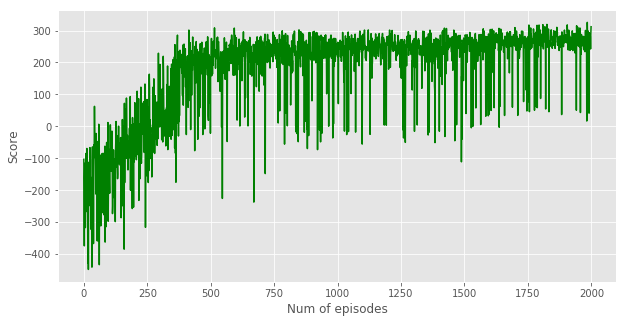

In [17]:
plt.figure(figsize=(10,5))
plt.plot(np.arange(len(scores)), scores, color='green')
plt.xlabel('Num of episodes')
plt.ylabel('Score')
if not os.path.exists('./images/'): os.makedirs('./images/')
plt.savefig('./images/plot_of_agent_evaluation.png')
plt.show()

## Watch The Smart Agent

In [18]:
# load the weights of smart agent
agent.dqn_net.load_state_dict(torch.load(f'./agents/Noisy_DQN_with_EGP_{ENV_NAME}.pth'));

In [19]:
num_of_episodes = 20

for i_episode in range(1, num_of_episodes+1):
    
    state = env.reset()
    for time_step in range(200):
        
        # select an action
        action = agent.act(state)
        env.render()
        
        next_state, reward, done, _ = env.step(action)
        state = next_state
        if done:
            break

env.close()

---